In [3]:
import sys
module_path = 'C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT'
sys.path.insert(1, module_path)
import Meta_SCMT
import numpy as np
import matplotlib.pyplot as plt

In [4]:
GP = {
    'dim' : 1, #dim : 1 or 2.
    'modes' : 1, #number of modes with in a single waveguide. modes <= 2 is usually good enough.
    'period' : 0.28,
    'res' : 20, #resolution within one period
    'downsample_ratio': 1, #between (0, 1] for the output periodic resolution, it will be int(round(downsample_ratio * res))
    'wh' : 0.6, #waveguide height
    'lam' : 0.66,
    'n_sub' : 1.46, #the refractive index of substrate.
    'n_wg' : 2.4,# the refractive index of waveguide
    'h_min' : 0.06, #h_min, and h_max define the range of the width of waveguide.
    'h_max' : 0.27,
    'dh' : 0.01, #the step size of h.
    'path' : "sim_cache_660nm/", #the inter state store path            
}
sim = Meta_SCMT.Sim(**GP)

If dowmsample_ratio changed, if only need to rerun fitting E.
It is ok to change n_sub, which is decoupled with the cached data.


# From step 1 to step 3, you parpare the data and model you need to build a SCMT model. Once done, the cache data is stored in "sim_cache_1D" directory. When you need to run or build your model agian, you just load the data from cache.

# step1 generate modes

# it's ok to see warning like invalid value encountered in sqrt. This is because when using fsolve function, it can feed bad bata in function. This won't influence the final results.

In [5]:
sim.gen_modes.gen(load = True)
sim.gen_modes.count_modes()

modes lib load sucessed.
total keys:  23
number of non zero modes:  [23.]


# step 1.1 check correctness of the generated modes.

In [ ]:
sim.gen_modes.vis_neffs()

In [ ]:
# randomly visualize some generated modes.
H = [0.08, 0.2, 0.27]
sim.gen_modes.vis_field(H)

# step 2, fit a function (the fully connected network) to output the effective refractive index given a width of waveguide. this function will be used in the SCMT model. (The solid line represent the original data, dashed line represent the function output).
# after the fitting the data will be saved in the "sim_cache..." directory. 

In [ ]:
sim.fitting_neffs.fit(vis=True, layers = 4, nodes = 128)

# step 2.1 check the correctness of fitting.

In [ ]:
neffs = sim.fitting_neffs.apply(H)
print(neffs)

# step 3.1 fit a function that given the widths and the distance between two waveguides i and j, output the coupling efficient Cij for the combination of all modes. 
# Eg: fit_c(hi, hj, dis) -> [cij_00, cij_01, cij_10, cij_11] if you have two modes per waveguide.

In [ ]:
sim.fftting_C.fit(load = False, vis=True, steps = 10000, nodes = 128, layers = 6)

# the max(C_ij) indicate how strong your system's coupling is. the sweet point is below 0.5 but above 0.1, based on experience.

# step 3.2 fit a function that given the width of the waveguide, output the Ey field for each mode.

In [ ]:
#randomly select 3 modes to visualize
sim.fftting_E.fit(vis=True, nodes = 128, layers = 6)

# step 3.3 fitting K, this is similiar to fit C

In [ ]:
sim.fftting_K.fit(load = False, vis=True, nodes = 128,layers = 6, steps = 30000)

# step 4 run a forward simulation.

In [ ]:
N = 3
#the widths of waveguides.
wgs = np.array([0.08, 0.15, 0.27])
prop_dis = 0.25 * N * GP['period']
#near field. the field at the exit of the waveguides.
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward()
sim.scmt.vis_field(E_out)

In [ ]:
#far field, the field propagates a distance in free space.
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= True)
E_out =sim.scmt.forward()
sim.scmt.vis_field(E_out)

# if no coupling: quite different from the scmt case, which indicate the coupling is important in this case.

In [ ]:
N = 3
#the widths of waveguides.
wgs = np.array([0.08, 0.15, 0.27])
prop_dis = 0.25 * N * GP['period']
#near field. the field at the exit of the waveguides.
sim.scmt.init_model(N, prop_dis, COUPLING = False, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward()
sim.scmt.vis_field(E_out)

# step 4.1 we do a fullwave simulation using Tidy3d to validate our forward process.

In [6]:
sim.fullwave.init_sim(prop_dis, N, wgs, res = 40)

NameError: name 'prop_dis' is not defined

In [ ]:
#upload the initualized sim to the sever. 
sim.fullwave.upload(task_name="3_wgs")

In [ ]:
#download the results to local once done.
sim.fullwave.download(data_path="output_tidy3d/")

In [ ]:
#wave goes up down.
Ey_xz_raw, data_near, data_far = sim.fullwave.vis_monitor()

# gen library for PBA design

In [ ]:
sim.PBA.gen_lib()

In [10]:
wgs_path = "PBA_lens_N20_lam0.59um.npy"
N = 20
NA = 0.8
theta = 0
prop_dis = 0.5 * N * GP['period'] * np.sqrt((1 - NA**2)/NA**2)
wgs = np.load(wgs_path)

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initial widths larger than h_max, replaced by h_max
initialized by loaded h_paras.


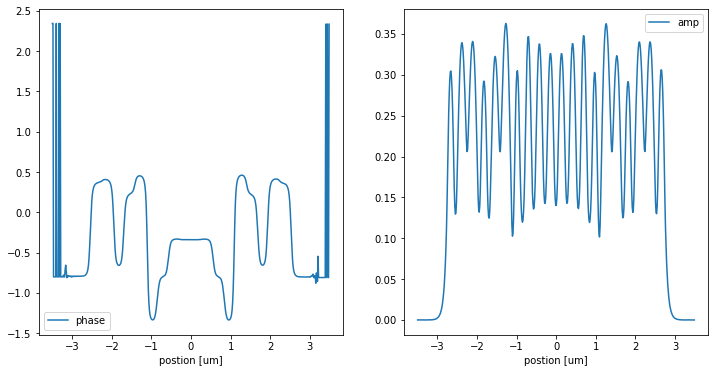

In [11]:
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward(theta = theta)
sim.scmt.vis_field(E_out)
E_scmt = E_out

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initial widths larger than h_max, replaced by h_max
initialized by loaded h_paras.


C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\SCMT_1D.py:197: UserWarning: bad initial widths for waveguides.
  warnings.warn("bad initial widths for waveguides.")


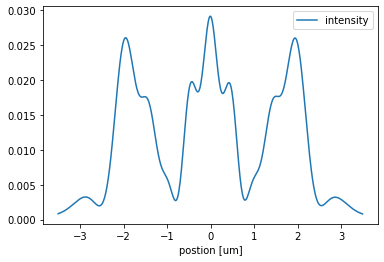

In [12]:
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= True)
E_out =sim.scmt.forward(theta = theta)
sim.scmt.vis_field(E_out)

# fullwave

In [ ]:
sim.fullwave.init_sim(prop_dis, N, wgs, res = 50, theta = theta)

In [ ]:
sim.fullwave.upload(task_name="1D_lens_N20")
sim.fullwave.download(data_path="output_tidy3d/")

In [ ]:
Ey_xz_raw, data_near, data_far = sim.fullwave.vis_monitor()

In [ ]:
def get_phase_offset(E1, E2):
    L2_dis = np.inf
    theta_opt = 0
    for theta in np.linspace(0, 2 * np.pi, 300):
        E_temp = E1 * np.exp(1j * theta)
        phase_temp = np.angle(E_temp)
        phase2 = np.angle(E2)
        dis_temp = ((phase_temp - phase2)**2).sum()
        if dis_temp < L2_dis:
            L2_dis = dis_temp
            theta_opt = theta
    print("minimum phase l2 dis:", L2_dis)
    return theta_opt

In [ ]:
E_fullwave = data_near['Ey']
b = 50
ph1_offset = get_phase_offset(E_scmt[b:-b], E_fullwave[b:-b])

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(np.angle(E_scmt * np.exp(1j * ph1_offset)))
plt.plot(np.angle(E_fullwave))

# the phase of fullwave

In [ ]:
fw_phase = np.flip(np.angle(Ey_xz_raw), axis = 0)

In [ ]:
import plotly.express as px

In [ ]:
fig = px.imshow(fw_phase)
fig.show()

In [ ]:
fw_phase.shape

In [ ]:
20 *20